In [4]:
from pprint import pprint
import os
import setproctitle

class Config:
    name = 'DeepCrack_CT260_FT1'

    gpu_id = '0,1,2,3'

    setproctitle.setproctitle("%s" % name)

    # path
    train_data_path = 'data/train_example.txt'
    val_data_path = 'data/test_example.txt'
    checkpoint_path = 'checkpoints'
    log_path = 'log'
    saver_path = os.path.join(checkpoint_path, name)
    max_save = 20

    # visdom
    vis_env = 'DeepCrack'
    port = 8097
    vis_train_loss_every = 40
    vis_train_acc_every = 40
    vis_train_img_every = 120
    val_every = 200

    # training
    epoch = 500
    pretrained_model = ''
    weight_decay = 0.0000
    lr_decay = 0.1
    lr = 1e-3
    momentum = 0.9
    use_adam = True  # Use Adam optimizer
    train_batch_size = 8
    val_batch_size = 4
    test_batch_size = 4

    acc_sigmoid_th = 0.5
    pos_pixel_weight = 1

    # checkpointer
    save_format = ''
    save_acc = -1
    save_pos_acc = -1

    def _parse(self, kwargs):
        state_dict = self._state_dict()
        for k, v in kwargs.items():
            if k not in state_dict:
                raise ValueError('UnKnown Option: "--%s"' % k)
            setattr(self, k, v)

        print('======user config========')
        pprint(self._state_dict())
        print('==========end============')

    def _state_dict(self):
        return {k: getattr(self, k) for k, _ in Config.__dict__.items() \
                if not k.startswith('_')}

    def show(self):
        print('======user config========')
        pprint(self._state_dict())
        print('==========end============')

In [6]:
from data.augmentation import augCompose, RandomBlur, RandomColorJitter
from data.dataset import readIndex, dataReadPip, loadedDataset
from tqdm import tqdm
from model.deepcrack import DeepCrack
from trainer import DeepCrackTrainer
from config import Config as cfg
import numpy as np
import torch
import os
import cv2
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpu_id


def main():
    # ----------------------- dataset ----------------------- #

    data_augment_op = augCompose(transforms=[[RandomColorJitter, 0.5], [RandomBlur, 0.2]])

    train_pipline = dataReadPip(transforms=data_augment_op)

    test_pipline = dataReadPip(transforms=None)

    train_dataset = loadedDataset(readIndex(cfg.train_data_path, shuffle=True), preprocess=train_pipline)

    test_dataset = loadedDataset(readIndex(cfg.test_data_path), preprocess=test_pipline)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.train_batch_size,
                                               shuffle=True, num_workers=4, drop_last=True)

    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=cfg.val_batch_size,
                                             shuffle=False, num_workers=4, drop_last=True)

    # -------------------- build trainer --------------------- #

    device = torch.device("cuda")
    num_gpu = torch.cuda.device_count()

    model = DeepCrack()
    model = torch.nn.DataParallel(model, device_ids=range(num_gpu))
    model.to(device)

    trainer = DeepCrackTrainer(model).to(device)

    if cfg.pretrained_model:
        pretrained_dict = trainer.saver.load(cfg.pretrained_model, multi_gpu=True)
        model_dict = model.state_dict()

        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        trainer.vis.log('load checkpoint: %s' % cfg.pretrained_model, 'train info')

    try:

        for epoch in range(1, cfg.epoch):
            trainer.vis.log('Start Epoch %d ...' % epoch, 'train info')
            model.train()

            # ---------------------  training ------------------- #
            bar = tqdm(enumerate(train_loader), total=len(train_loader))
            bar.set_description('Epoch %d --- Training --- :' % epoch)
            for idx, (img, lab) in bar:
                data, target = img.type(torch.cuda.FloatTensor).to(device), lab.type(torch.cuda.FloatTensor).to(device)
                pred = trainer.train_op(data, target)
                if idx % cfg.vis_train_loss_every == 0:
                    trainer.vis.log(trainer.log_loss, 'train_loss')
                    trainer.vis.plot_many({
                        'train_total_loss': trainer.log_loss['total_loss'],
                        'train_output_loss': trainer.log_loss['output_loss'],
                        'train_fuse5_loss': trainer.log_loss['fuse5_loss'],
                        'train_fuse4_loss': trainer.log_loss['fuse4_loss'],
                        'train_fuse3_loss': trainer.log_loss['fuse3_loss'],
                        'train_fuse2_loss': trainer.log_loss['fuse2_loss'],
                        'train_fuse1_loss': trainer.log_loss['fuse1_loss'],
                    })

                if idx % cfg.vis_train_acc_every == 0:
                    trainer.acc_op(pred[0], target)
                    trainer.vis.log(trainer.log_acc, 'train_acc')
                    trainer.vis.plot_many({
                        'train_mask_acc': trainer.log_acc['mask_acc'],
                        'train_mask_pos_acc': trainer.log_acc['mask_pos_acc'],
                        'train_mask_neg_acc': trainer.log_acc['mask_neg_acc'],
                    })
                if idx % cfg.vis_train_img_every == 0:
                    trainer.vis.img_many({
                        'train_img': data.cpu(),
                        'train_output': torch.sigmoid(pred[0].contiguous().cpu()),
                        'train_lab': target.unsqueeze(1).cpu(),
                        'train_fuse5': torch.sigmoid(pred[1].contiguous().cpu()),
                        'train_fuse4': torch.sigmoid(pred[2].contiguous().cpu()),
                        'train_fuse3': torch.sigmoid(pred[3].contiguous().cpu()),
                        'train_fuse2': torch.sigmoid(pred[4].contiguous().cpu()),
                        'train_fuse1': torch.sigmoid(pred[5].contiguous().cpu()),
                    })

                if idx % cfg.val_every == 0:
                    trainer.vis.log('Start Val %d ....' % idx, 'train info')
                    # -------------------- val ------------------- #
                    model.eval()
                    val_loss = {
                        'eval_total_loss': 0,
                        'eval_output_loss': 0,
                        'eval_fuse5_loss': 0,
                        'eval_fuse4_loss': 0,
                        'eval_fuse3_loss': 0,
                        'eval_fuse2_loss': 0,
                        'eval_fuse1_loss': 0,
                    }
                    val_acc = {
                        'mask_acc': 0,
                        'mask_pos_acc': 0,
                        'mask_neg_acc': 0,
                    }

                    bar.set_description('Epoch %d --- Evaluation --- :' % epoch)

                    with torch.no_grad():
                        for idx, (img, lab) in enumerate(val_loader, start=1):
                            val_data, val_target = img.type(torch.cuda.FloatTensor).to(device), lab.type(
                                torch.cuda.FloatTensor).to(device)
                            val_pred = trainer.val_op(val_data, val_target)
                            trainer.acc_op(val_pred[0], val_target)
                            val_loss['eval_total_loss'] += trainer.log_loss['total_loss']
                            val_loss['eval_output_loss'] += trainer.log_loss['output_loss']
                            val_loss['eval_fuse5_loss'] += trainer.log_loss['fuse5_loss']
                            val_loss['eval_fuse4_loss'] += trainer.log_loss['fuse4_loss']
                            val_loss['eval_fuse3_loss'] += trainer.log_loss['fuse3_loss']
                            val_loss['eval_fuse2_loss'] += trainer.log_loss['fuse2_loss']
                            val_loss['eval_fuse1_loss'] += trainer.log_loss['fuse1_loss']
                            val_acc['mask_acc'] += trainer.log_acc['mask_acc']
                            val_acc['mask_pos_acc'] += trainer.log_acc['mask_pos_acc']
                            val_acc['mask_neg_acc'] += trainer.log_acc['mask_neg_acc']
                        else:
                            trainer.vis.img_many({
                                'eval_img': val_data.cpu(),
                                'eval_output': torch.sigmoid(val_pred[0].contiguous().cpu()),
                                'eval_lab': val_target.unsqueeze(1).cpu(),
                                'eval_fuse5': torch.sigmoid(val_pred[1].contiguous().cpu()),
                                'eval_fuse4': torch.sigmoid(val_pred[2].contiguous().cpu()),
                                'eval_fuse3': torch.sigmoid(val_pred[3].contiguous().cpu()),
                                'eval_fuse2': torch.sigmoid(val_pred[4].contiguous().cpu()),
                                'eval_fuse1': torch.sigmoid(val_pred[5].contiguous().cpu()),

                            })
                            trainer.vis.plot_many({
                                'eval_total_loss': val_loss['eval_total_loss'] / idx,
                                'eval_output_loss': val_loss['eval_output_loss'] / idx,
                                'eval_fuse5_loss': val_loss['eval_fuse5_loss'] / idx,
                                'eval_fuse4_loss': val_loss['eval_fuse4_loss'] / idx,
                                'eval_fuse3_loss': val_loss['eval_fuse3_loss'] / idx,
                                'eval_fuse2_loss': val_loss['eval_fuse2_loss'] / idx,
                                'eval_fuse1_loss': val_loss['eval_fuse1_loss'] / idx,

                            })
                            trainer.vis.plot_many({
                                'eval_mask_acc': val_acc['mask_acc'] / idx,
                                'eval_mask_neg_acc': val_acc['mask_neg_acc'] / idx,
                                'eval_mask_pos_acc': val_acc['mask_pos_acc'] / idx,

                            })
                            # ----------------- save model ---------------- #
                            if cfg.save_pos_acc < (val_acc['mask_pos_acc'] / idx) and cfg.save_acc < (
                                    val_acc['mask_acc'] / idx):
                                cfg.save_pos_acc = (val_acc['mask_pos_acc'] / idx)
                                cfg.save_acc = (val_acc['mask_acc'] / idx)
                                trainer.saver.save(model, tag='%s_epoch(%d)_acc(%0.5f/%0.5f)' % (
                                    cfg.name, epoch, cfg.save_pos_acc, cfg.save_acc))
                                trainer.vis.log('Save Model %s_epoch(%d)_acc(%0.5f/%0.5f)' % (
                                    cfg.name, epoch, cfg.save_pos_acc, cfg.save_acc), 'train info')

                    bar.set_description('Epoch %d --- Training --- :' % epoch)
                    model.train()

            if epoch != 0:
                trainer.saver.save(model, tag='%s_epoch(%d)' % (
                    cfg.name, epoch))
                trainer.vis.log('Save Model -%s_epoch(%d)' % (
                    cfg.name, epoch), 'train info')

    except KeyboardInterrupt:

        trainer.saver.save(model, tag='Auto_Save_Model')
        print('\n Catch KeyboardInterrupt, Auto Save final model : %s' % trainer.saver.show_save_pth_name)
        trainer.vis.log('Catch KeyboardInterrupt, Auto Save final model : %s' % trainer.saver.show_save_pth_name,
                        'train info')
        trainer.vis.log('Training End!!')
        try:
            sys.exit(0)
        except SystemExit:
            os._exit(0)


if __name__ == '__main__':
    main()

In [8]:
from data.dataset import readIndex, dataReadPip, loadedDataset
from model.deepcrack import DeepCrack
from trainer import DeepCrackTrainer
import cv2
from tqdm import tqdm
import numpy as np
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


def test(test_data_path='data/test_example.txt',
         save_path='deepcrack_results/',
         pretrained_model='checkpoints/DeepCrack_CT260_FT1.pth', ):
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    test_pipline = dataReadPip(transforms=None)

    test_list = readIndex(test_data_path)

    test_dataset = loadedDataset(test_list, preprocess=test_pipline)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                              shuffle=False, num_workers=1, drop_last=False)

    # -------------------- build trainer --------------------- #

    device = torch.device("cuda")
    num_gpu = torch.cuda.device_count()

    model = DeepCrack()

    model = torch.nn.DataParallel(model, device_ids=range(num_gpu))
    model.to(device)

    trainer = DeepCrackTrainer(model).to(device)

    model.load_state_dict(trainer.saver.load(pretrained_model, multi_gpu=True))

    model.eval()

    with torch.no_grad():
        for names, (img, lab) in tqdm(zip(test_list, test_loader)):
            test_data, test_target = img.type(torch.cuda.FloatTensor).to(device), lab.type(torch.cuda.FloatTensor).to(
                device)
            test_pred = trainer.val_op(test_data, test_target)
            test_pred = torch.sigmoid(test_pred[0].cpu().squeeze())
            save_pred = torch.zeros((512 * 2, 512))
            save_pred[:512, :] = test_pred
            save_pred[512:, :] = lab.cpu().squeeze()
            save_name = os.path.join(save_path, os.path.split(names[1])[1])
            save_pred = save_pred.numpy() * 255
            cv2.imwrite(save_name, save_pred.astype(np.uint8))


if __name__ == '__main__':
    test()

---
---
---
---
---
---
---
---
---
---


In [12]:

from torch import nn
from tools.visdom import Visualizer
from tools.checkpointer import Checkpointer
from config import Config as cfg
import torch


def get_optimizer(model):
    if cfg.use_adam:
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    else:
        return torch.optim.SGD(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, momentum=cfg.momentum, )


class DeepCrackTrainer(nn.Module):
    def __init__(self, model):
        super(DeepCrackTrainer, self).__init__()
        self.vis = Visualizer(env=cfg.vis_env)
        self.model = model

        self.saver = Checkpointer(cfg.name, cfg.saver_path, overwrite=False, verbose=True, timestamp=True,
                                  max_queue=cfg.max_save)

        self.optimizer = get_optimizer(self.model)

        self.iter_counter = 0

        # -------------------- Loss --------------------- #

        self.mask_loss = nn.BCEWithLogitsLoss(reduction='mean',
                                              pos_weight=torch.cuda.FloatTensor([cfg.pos_pixel_weight]))

        self.log_loss = {}
        self.log_acc = {}

    def train_op(self, input, target):
        self.optimizer.zero_grad()

        pred_output, pred_fuse5, pred_fuse4, pred_fuse3, pred_fuse2, pred_fuse1, = self.model(input)

        output_loss = self.mask_loss(pred_output.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse5_loss = self.mask_loss(pred_fuse5.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse4_loss = self.mask_loss(pred_fuse4.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse3_loss = self.mask_loss(pred_fuse3.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse2_loss = self.mask_loss(pred_fuse2.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse1_loss = self.mask_loss(pred_fuse1.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size

        total_loss = output_loss + fuse5_loss + fuse4_loss + fuse3_loss + fuse2_loss + fuse1_loss
        total_loss.backward()
        self.optimizer.step()

        self.iter_counter += 1

        self.log_loss = {
            'total_loss': total_loss.item(),
            'output_loss': output_loss.item(),
            'fuse5_loss': fuse5_loss.item(),
            'fuse4_loss': fuse4_loss.item(),
            'fuse3_loss': fuse3_loss.item(),
            'fuse2_loss': fuse2_loss.item(),
            'fuse1_loss': fuse1_loss.item()
        }

        return pred_output, pred_fuse5, pred_fuse4, pred_fuse3, pred_fuse2, pred_fuse1,

    def val_op(self, input, target):
        pred_output, pred_fuse5, pred_fuse4, pred_fuse3, pred_fuse2, pred_fuse1, = self.model(input)

        output_loss = self.mask_loss(pred_output.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse5_loss = self.mask_loss(pred_fuse5.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse4_loss = self.mask_loss(pred_fuse4.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse3_loss = self.mask_loss(pred_fuse3.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse2_loss = self.mask_loss(pred_fuse2.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size
        fuse1_loss = self.mask_loss(pred_fuse1.view(-1, 1), target.view(-1, 1)) / cfg.train_batch_size

        total_loss = output_loss + fuse5_loss + fuse4_loss + fuse3_loss + fuse2_loss + fuse1_loss

        self.log_loss = {
            'total_loss': total_loss.item(),
            'output_loss': output_loss.item(),
            'fuse5_loss': fuse5_loss.item(),
            'fuse4_loss': fuse4_loss.item(),
            'fuse3_loss': fuse3_loss.item(),
            'fuse2_loss': fuse2_loss.item(),
            'fuse1_loss': fuse1_loss.item()
        }

        return pred_output, pred_fuse5, pred_fuse4, pred_fuse3, pred_fuse2, pred_fuse1,

    def acc_op(self, pred, target):
        mask = target

        pred = pred
        pred[pred > cfg.acc_sigmoid_th] = 1
        pred[pred <= cfg.acc_sigmoid_th] = 0

        pred_mask = pred[:, 0, :, :].contiguous()

        mask_acc = pred_mask.eq(mask.view_as(pred_mask)).sum().item() / mask.numel()
        mask_pos_acc = pred_mask[mask > 0].eq(mask[mask > 0].view_as(pred_mask[mask > 0])).sum().item() / mask[
            mask > 0].numel()
        mask_neg_acc = pred_mask[mask < 1].eq(mask[mask < 1].view_as(pred_mask[mask < 1])).sum().item() / mask[
            mask < 1].numel()

        self.log_acc = {
            'mask_acc': mask_acc,
            'mask_pos_acc': mask_pos_acc,
            'mask_neg_acc': mask_neg_acc,
        }

\
    name = 'merged_google_crack_images'\
    in_dir = f'/home/noor/data_1/courses/practical_project_1/codes/dataset/google_images/{name}'\
    out_dir = '/home/noor/data_1/courses/practical_project_1/codes/dataset/google_images/'\
    paths = [path for path in Path(in_dir).glob('*.jpg')]
\
    name = 'merged_google_crack_images'\
    in_dir = f'/home/noor/data_1/courses/practical_project_1/codes/dataset/google_images/{name}'\
    out_dir = '/home/noor/data_1/courses/practical_project_1/codes/dataset/google_images/'\
    paths = [path for path in Path(in_dir).glob('*.jpg')]
\
    name = 'merged_google_crack_images'\
    in_dir = f'/home/noor/data_1/courses/practical_project_1/codes/dataset/google_images/{name}'\
    out_dir = '/home/noor/data_1/courses/practical_project_1/codes/dataset/google_images/'\
    paths = [path for path in Path(in_dir).glob('*.jpg')]
\
    name = 'merged_google_crack_images'\
    in_dir = f'/home/noor/data_1/courses/practical_project_1/codes/dataset/google_im

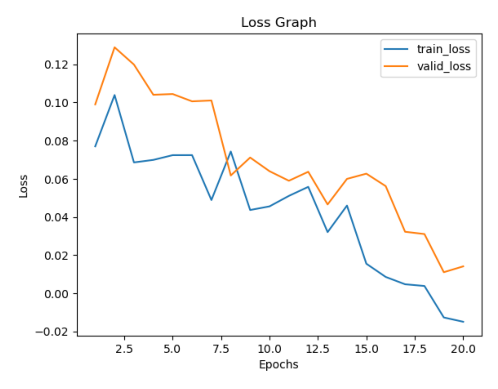

In [14]:
import argparse
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

if __name__ == '__main__':
    ap = argparse.ArgumentParser()
    ap.add_argument("-model_dir", type=str, required=True)
    ap.add_argument("-title", type=str, required=True)
    args = ap.parse_args()

    paths = [path for path in Path(args.model_dir).glob('*.pt')]
    paths = sorted(paths)
    epochs = []
    tr_losses = []
    vl_losses = []
    for path in tqdm(paths):
        if 'epoch' not in path.stem:
            continue
        #load the min loss so far
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)
        state = torch.load(path)
        val_los = state['valid_loss']
        train_loss = float(state['train_loss'])
        tr_losses.append(train_loss)
        vl_losses.append(val_los)

    sorted_idxs = np.argsort(epochs)
    tr_losses = [tr_losses[idx] for idx in sorted_idxs]
    vl_losses = [vl_losses[idx] for idx in sorted_idxs]

    print(tr_losses)
    print(vl_losses)

    plt.plot(tr_losses[1:], label='train_loss')
    plt.plot(vl_losses[1:], label='valid_loss')
    plt.title(args.title)
    plt.legend()
    plt.show()